Name: Nguyễn Thọ Anh Khoa

Class: AI_INSIGHT 

Facebook: Khoa Nguyen KT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Exploitation of Pretrained Models
#&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Image Retrieval)

## 1) Các bạn download data và các file code mẫu ở link sau

https://www.dropbox.com/sh/q6knfbqr2h8lrwt/AADTAtYGuS9uA3GmhBAQa16Ea?dl=

## 2) Đọc hiểu code từ các file sau để hiểu về cách thao tác data và network cho bài toán Image Retrieval

- ImageRetrieval_DataPreparation.ipynb
- 11.1.ImageRetrieval-abs.ipynb
- 11.2.ImageRetrieval-cosine.ipynb
- 11.3.ImageRetrieval-CNN-Cosine.ipynb
- 11.4.ImageRetrieval-CNN-Correlation.ipynb
- 11.5.ImageRetrieval-CNN-PrecomputeFeatures.ipynb
- 11.6.ImageRetrieval-CNN-Cosine-UsingPrecomputed.ipynb
- 11.7.ImageRetrieval-CNN-Cosine_DifferentSize.ipynb

- Nếu save toàn bộ ảnh được load bằng np.save thì nên cast ảnh về uint8 để tiết kiệm dung lượng chứa ảnh 


### Image Retrieval absolute distance

Ý tưởng:

IN: 1 ảnh query 

OUT: list ảnh tương tự ảnh query 

- Đo distance bằng các tính tổng absolute khác biệt từng pixel giữa ảnh query và từng ảnh trong data, và sắp xếp theo thứ tự lớn đến bé. Cuối cùng chọn ra k picture có độ distance lớn nhất
- để có thể đo được khoảng cách nên flatten các size ảnh ra thành 1 vector, sau khi tính khoảng cách xong reshape lại các ảnh như cũ để hiển thị 
- Để query có shape bằng data thì cần dùng hàm np.tile để tạo ra nhiều bản sao của query 

In [ ]:
# compute abs
query_np = np.reshape(query_np,  (1, -1))
data  = np.reshape(data, (data.shape[0], -1))
print(query_np.shape)
print(data.shape)
query_np_tile = np.tile(query_np, (data.shape[0], 1))
print(query_np_tile.shape)
print(data.shape)

distances = np.absolute(query_np_tile - data)
distances = np.sum(distances, axis=1)
print(distances.shape)

### Cosine similarity

- computes the L2-normalized dot product of vectors
- Đo độ tương tự trong range [0,1], và cách thực hiện như abs 
- Công thức $k(x, y) = \frac{x y^\top}{\|x\| \|y\|}$ trong đó x, y được xem là vector row.
- Thư viện hỗ trợ from sklearn.metrics.pairwise import cosine_similarity (không cần tạo ra bản sao query)


In [ ]:
# compute cosine
query_np = np.reshape(query_np,  (1, -1))
data = np.reshape(data, (data.shape[0], -1))
sims = cosine_similarity(query_np, data).squeeze()
print(sims.shape)

### CNN Cosine Similarity 

- Thay vì so sánh Cosine Similarity từng pixel trong ảnh (có thể dẫn đến kết quả không tốt vì từng pixel sẽ được kiếm cho gần giống nhau ví dụ màu sắc ... và đôi khi bỏ qua các feature quan trọng) thì ảnh query và data sẽ được đi qua 1 SOTA pretrained network để extract feature. Sau đó dùng feature này so sánh như cách làm với thuần Cosine Similarity ở trên.



- Có một điểm giới hạn là do dùng pretrained model nên ảnh nên có shape giống yêu cầu cảu model đó 

### CNN Correlation 

Tương tự như CNN Cosine Similarity, nhưng metric được sử dụng là Corrlation 
- Công thức $r_{pb} = \frac{\sum (x - m_x) (y - m_y)}{\sqrt{\sum (x - m_x)^2 (y - m_y)^2}}$ trong đó x, y là các vector cần so sánh và m là mean của từng vector 
- Thư viện hỗ trợ from scipy.stats.stats import pearsonr


In [ ]:
# compute correlation
corr_list = []
for i in range(data.shape[0]):
  corr = pearsonr(query_features[0], data_features[i])
  corr_list.append(corr)
print(len(corr_list))

**NOTE**:
- Đôi khi compute features của data không thể toàn bộ 1 lần được vì giới hạn của CPU hoặc GPU do đó có thể chia theo batch để compute sau đó concatenate lại 

In [ ]:
def compute_features(data):
  result = []
  chunk_size = 500
  num_chunks = data.shape[0]//chunk_size + 1   #roughtly

  for c in range(num_chunks):
    # batch
    begin = chunk_size*c
    end   = min(chunk_size*(c+1), data.shape[0])
    data_chunk = data[begin:end]

    # compute features for the batch
    data_chunk = compute_feature_help(data_chunk)
    result.append(data_chunk)

  return result

**NOTE**
- Đối với trường hợp ảnh không thể fit input shape của pretrained model thì có thể sử  dụng bằng cách chọn các layer có input size thích hợp 

In [ ]:
def compute_feature_help(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

**NOTE**
- Trong thực tế để cho nhanh khi sử dụng với data base của mình thì nên extract toàn bộ feature và save vào 1 file. Khi query thì chỉ cần extrac feature của ảnh query và so sánh với file đã save.

## 3) (Optional) Các bạn thay thế VGG16 pretrained model bằng một model khác (ví dụ InceptionV3) để quan sát xem performance của giải thuật có thay đổi khi dùng các pretrained model khác nhau.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image as kimage
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.stats import pearsonr

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/images_mr2.npy"
data = np.load(data_path, allow_pickle=True)
data.shape


(9908, 86, 128, 3)

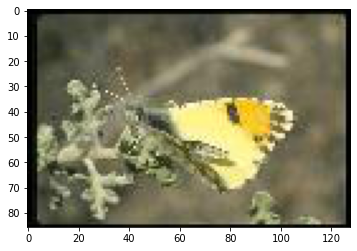

In [ ]:
plt.imshow(data[0])

In [ ]:
InceptionV3 = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(86,128,3))

In [ ]:
InceptionV3 = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(86,128,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 86, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 42, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 42, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 42, 63, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
# feature map 1*2*2048
from tqdm import tqdm

def data_features_helper(data):
  data = tf.keras.applications.inception_v3.preprocess_input(data)
  # data = tf.keras.applications.vgg16.preprocess_input(data)
  batch_size = 200
  steps = data.shape[0]//batch_size + 1
  results = []
  for step in tqdm(range(steps)):
    beg = step*batch_size
    end = min((step+1)*batch_size, data.shape[0])
    subdata = data[beg:end]
    subdata_feature = InceptionV3(subdata)
    results.append(subdata_feature)
  return results

In [ ]:
results = data_features_helper(data)

100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


In [ ]:
feature_Inception = np.concatenate(results)
feature_Inception.shape

(9908, 1, 2, 2048)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/feature_Inception.npy', feature_Inception)

In [ ]:
feature_Inception = np.load('/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/feature_Inception.npy', allow_pickle=True)

(1, 86, 128, 3)
<class 'numpy.ndarray'>


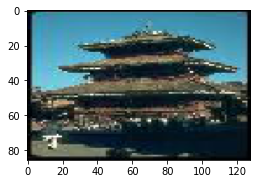

In [ ]:
# load query
PATH = "/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/image-retrieval/"
query = kimage.load_img(PATH+'q2.jpg', target_size=(86, 128))
query_np = kimage.img_to_array(query) #(86, 128, 3)

query_np = np.expand_dims(query_np, axis=0)  # (1, 86, 128, 3)
print(query_np.shape)
print(type(query_np))

# show query
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.imshow(query_np[0]/255.0)

In [ ]:
# query_np = tf.keras.applications.vgg16.preprocess_input(query_np)
query_np = tf.keras.applications.inception_v3.preprocess_input(query_np)
query_np = InceptionV3(query_np)
query_np.shape

TensorShape([1, 1, 2, 2048])

In [ ]:
query_np = np.reshape(query_np, (1, -1))
feature_Inception = np.reshape(feature_Inception, (feature_Inception.shape[0], -1))

In [ ]:
cs_result = cosine_similarity(query_np, feature_Inception)

In [ ]:
cs_result[0].shape

(9908,)

In [ ]:
def getKey(item):
    return item[0]

lists = [i for i in range(feature_Inception.shape[0])]
tp = zip(cs_result[0].tolist(), lists)
tp_s = sorted(tp, key=getKey, reverse=True)

for i in range(8):
    print(tp_s[i])

(1.0000001192092896, 3425)
(0.5863994359970093, 3478)
(0.5593132376670837, 3916)
(0.5571914911270142, 3119)
(0.5570734143257141, 279)
(0.5514257550239563, 3243)
(0.5482908487319946, 8257)
(0.5416811108589172, 4001)


(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)
(86, 128, 3)


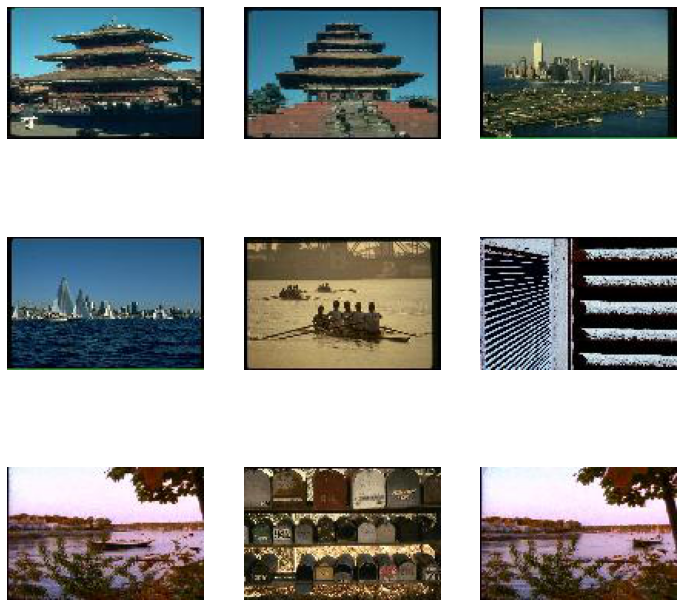

In [ ]:
fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tp_s[i-1][1]
    img = data[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    print(img.shape)
    plt.imshow(img.reshape((86, 128, 3)).astype(np.uint8))

In [ ]:
corr_list = []
for i in range(feature_Inception.shape[0]):
  corr = pearsonr(query_np[0], feature_Inception[i])
  corr_list.append(corr)
print(len(corr_list))

9908


In [ ]:
tps = zip(corr_list, lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

for i in range(8):
    print(tps_sorted[i])

((0.9999999945696685, 0.0), 3425)
((0.4405748653915086, 3.99994546907133e-194), 3478)
((0.41394424913111555, 2.42253129456622e-169), 3916)
((0.40964198536284413, 1.520661627458454e-165), 3119)
((0.4013445086188373, 2.2411641979802954e-158), 8257)
((0.39026451630851566, 4.063845323469883e-149), 3640)
((0.38934430661987707, 2.301456917397563e-148), 6333)
((0.3871964263740702, 1.2894220780125332e-146), 8256)


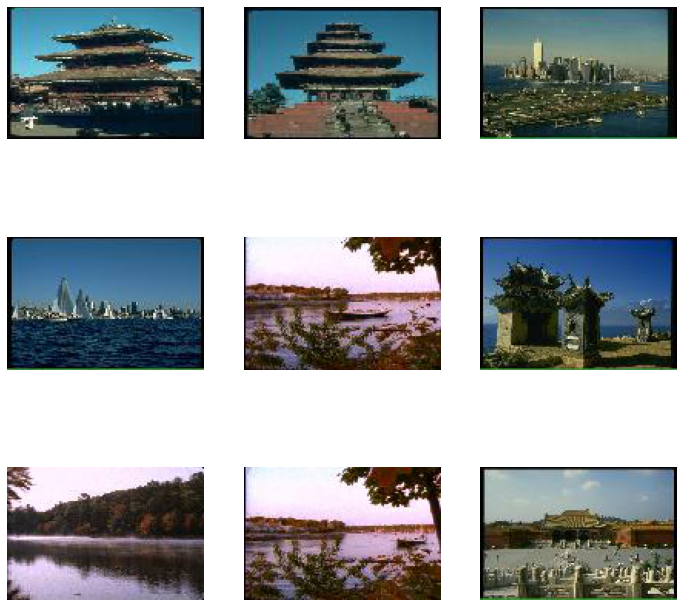

In [ ]:
fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]

    img = data[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)

**Mặc dù vgg16 có ít parmeter hơn InceptionV3 (14 và 21 M) nhưng VGG16 dường cho feature tốt hơn để  đo độ tương tự**

## 4) (Optional) Chúng ta có thể sử dụng Fashion-MNIST data cho bài toán Image Retrieval.
- Ở mỗi category, chúng ta lấy ngẫu nhiên một hình để làm hình query. Dữ liệu còn lại làm dữ liệu database.
- Dựa vào code từ câu (2), các bạn áp dụng cho data chỉnh sửa từ data Fashion-MNIST

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.stats import pearsonr


In [ ]:
Fashion_MNIST = keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = Fashion_MNIST

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
classes = np.unique(y_train)
idx_query = [np.where(y_train==cl)[0][0] for cl in classes]
query_imgs = x_train[idx_query]
query_imgs.shape

(10, 28, 28)

In [ ]:
database = np.asarray([img for idx, img in enumerate(x_train) if idx not in idx_query])
database.shape

(59990, 28, 28)

In [ ]:
query_imgs = x_train[idx_query]
query_imgs = np.asarray([np.tile(np.expand_dims(cv2.resize(qimg, (56,56)), axis=-1), (1,1,3)) for qimg in query_imgs])
query_imgs.shape

(10, 56, 56, 3)

In [ ]:
database = [img for idx, img in enumerate(x_train) if idx not in idx_query]
database = np.asarray([np.tile(np.expand_dims(cv2.resize(dimg, (56,56)), axis=-1), (1,1,3)) for dimg in database])
database.shape

(59990, 56, 56, 3)

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(56, 56, 3), weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [ ]:
def get_database_feature(database, vgg16):
  database = tf.keras.applications.vgg16.preprocess_input(database)
  num_samples = database.shape[0]
  batch_size = 200
  steps = num_samples//batch_size +1
  results = []
  for step in tqdm(range(steps)):
    beg = step*batch_size
    end = min((step+1)*batch_size, num_samples)
    subdata = database[beg:end]
    feature_subdata = vgg16(subdata)
    results.append(feature_subdata)
  return results


In [ ]:
fMNIST_features_database = get_database_feature(database, vgg16)
fMNIST_features_database = np.concatenate(fMNIST_features_database, axis=0)
fMNIST_features_database.shape

100%|██████████| 300/300 [00:57<00:00,  5.19it/s]


(59990, 1, 1, 512)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/fMNIST_features_database.npy', fMNIST_features_database)

In [ ]:
fMNIST_features_database = np.load('/content/drive/MyDrive/Colab Notebooks/AI_INSIGHT/fMNIST_features_database.npy', allow_pickle=True)

In [ ]:
feature_query_imgs = vgg16(tf.keras.applications.vgg16.preprocess_input(query_imgs))
feature_query_imgs.shape

TensorShape([10, 1, 1, 512])

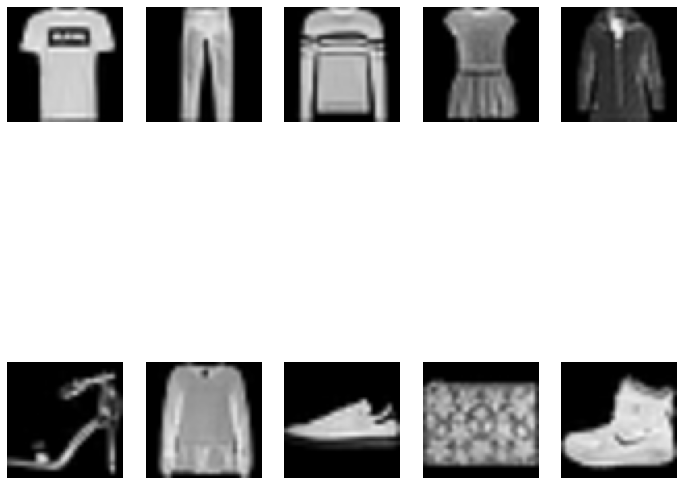

In [ ]:
fig = plt.figure(figsize=(12,12))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    index = i-1
    img = query_imgs[index]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img.reshape((56, 56, 3)).astype(np.uint8))

## Test with 0

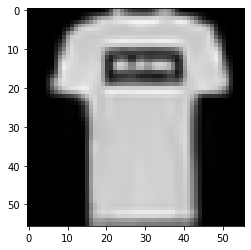

In [ ]:
plt.imshow(query_imgs[0]/255.0)

In [ ]:
corr_list = []
for i in range(fMNIST_features_database.shape[0]):
  base = np.reshape(feature_query_imgs[0], (1,-1))
  test = np.reshape(fMNIST_features_database[i], (1,-1))
  corr = pearsonr(np.squeeze(base), np.squeeze(test))
  corr_list.append(corr)
print(len(corr_list))

59990


In [ ]:
def getKey(item):
    return item[0]

lists = [i for i in range(fMNIST_features_database.shape[0])]
tps = zip(corr_list, lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

for i in range(8):
    print(tps_sorted[i])

((0.8640528787521119, 3.8664862176851027e-154), 56779)
((0.857875569156898, 1.3930970690824663e-149), 52938)
((0.8541158518173895, 6.502478448492498e-147), 32599)
((0.8416250771222302, 1.4751022862670014e-138), 5299)
((0.8415911162864735, 1.5507514819006308e-138), 15924)
((0.8292521948659562, 5.743719809976235e-131), 43121)
((0.829005409406673, 8.02281510033505e-131), 49589)
((0.8231266244898932, 1.9692168382722465e-127), 38117)


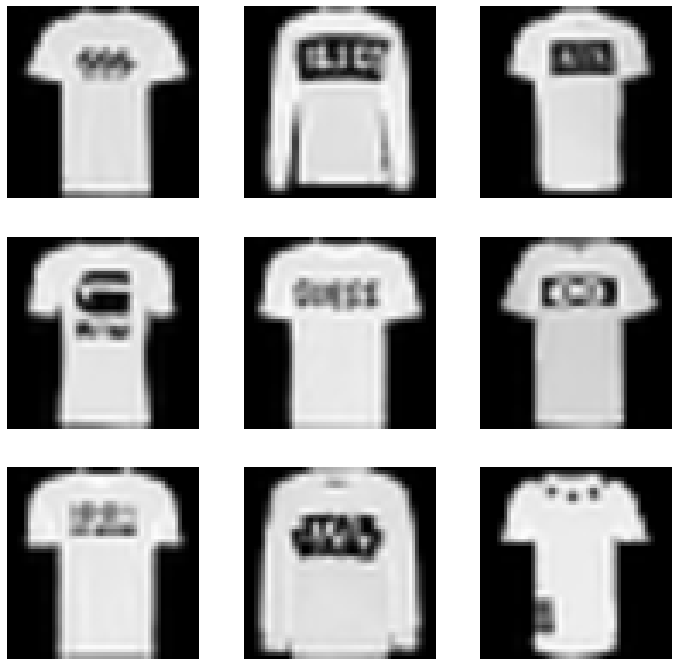

In [ ]:
fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]

    img = database[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)

### Test with 9

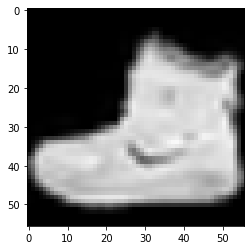

In [ ]:
plt.imshow(query_imgs[9]/255.0)

59990
((0.9287429525907815, 6.251240371876826e-222), 4393)
((0.92002191033706, 1.2152874391417586e-209), 38674)
((0.9189062659402961, 3.5890942280502107e-208), 49483)
((0.9131266417865638, 7.04654521942103e-201), 32576)
((0.9087288156048934, 1.1593048806912605e-195), 54937)
((0.9087037477930691, 1.2392739445843321e-195), 12205)
((0.9078272188462057, 1.261536511616096e-194), 25440)
((0.9071473638648513, 7.509255210972772e-194), 13654)


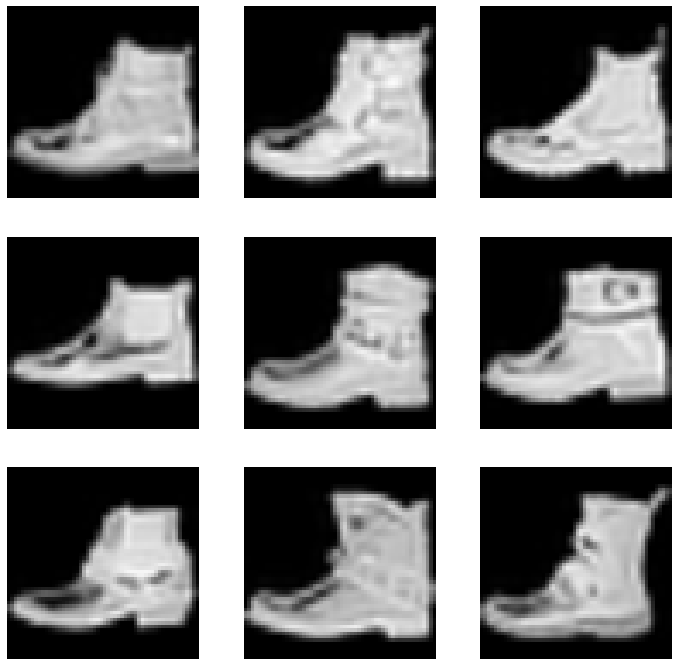

In [ ]:
corr_list = []
for i in range(fMNIST_features_database.shape[0]):
  base = np.reshape(feature_query_imgs[9], (1,-1))
  test = np.reshape(fMNIST_features_database[i], (1,-1))
  corr = pearsonr(np.squeeze(base), np.squeeze(test))
  corr_list.append(corr)
print(len(corr_list))

def getKey(item):
    return item[0]

lists = [i for i in range(fMNIST_features_database.shape[0])]
tps = zip(corr_list, lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

for i in range(8):
    print(tps_sorted[i])


fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]

    img = database[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)